In [239]:
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from typing import List, Tuple
from torch import Tensor
import random
from copy import deepcopy

In [240]:
def load_data(
        n_per_class: int,
        root: str = "../../data/mnist"):
    """

    :param n_per_class:
    :param root:
    :return: out[<train or test>(0,1), <digit>(0,...,9), <data or target>(0,1), batch_dim]
    """
    mnist_train = MNIST(root=root, train=True, download=True)
    mnist_test = MNIST(root=root, train=False, download=True)

    subsets_train = []
    subsets_test = []

    sets = [mnist_train, mnist_test]
    subsets = [subsets_train, subsets_test]
    for digit in range(10):
        for i in range(2):
            cond = sets[i].targets == digit
            data = sets[i].data[cond][:n_per_class].unsqueeze(1).float()
            targets = sets[i].targets[cond][:n_per_class].long()
            subsets[i].append([data, targets])
    return subsets


class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=3,
                kernel_size=3,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=3,
                out_channels=8,
                kernel_size=3,
                padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=8,
                out_channels=10,
                kernel_size=7),
            nn.Flatten())
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x: Tensor, y: Tensor):
        scores = self.layers(x)
        loss = self.loss(scores, y)
        return {"loss": loss, "scores": scores}

In [241]:
def sample_tasks(banned_task: Tuple[int, int]) -> Tuple[int, int]:
    while True:
        digit1 = random.randint(a=0, b=9)
        digit2 = random.randint(a=0, b=9)
        if digit1 != digit2:
            if set([digit1, digit2]) != set(banned_task):
                    return digit1, digit2

In [242]:
def acc(scores: Tensor, target: Tensor) -> float:
    preds = torch.argmax(scores, dim=1)
    return ((preds == target).sum() / len(target)).item()

def reptile_sgd(
        n_iters_outer: int,
        n_iters_inner: int,
        classifier: Classifier,
        lr_inner: float,
        lr_outer: float,
        banned_task: Tuple[int, int],
        data_test: Tuple[Tensor, Tensor],
        data_train: Tuple[Tensor, Tensor]):
    classifier.train()
    learned_tasks = []
    losses_train = []
    accs_train = []
    losses_test = []
    accs_test = []
    num_tasks = len(data_train)
    eval_data_train = torch.cat([data_train[task_id][0] for task_id in range(num_tasks)])
    eval_target_train = torch.cat([data_train[task_id][1] for task_id in range(num_tasks)])

    eval_data_test = torch.cat([data_test[task_id][0] for task_id in range(num_tasks)])
    eval_target_test = torch.cat([data_test[task_id][1] for task_id in range(num_tasks)])

    for i in range(n_iters_outer):
        if (i + 1) % 50 == 0:
            print("iteration", i + 1)
        classifier_inner = deepcopy(classifier)

        tasks_sampled = sample_tasks(banned_task=banned_task)
        learned_tasks.append(set(tasks_sampled))
        data = torch.cat([data_train[tasks_sampled[0]][0], data_train[tasks_sampled[1]][0]])
        target = torch.cat([data_train[tasks_sampled[0]][1], data_train[tasks_sampled[1]][1]])
        for j in range(n_iters_inner):
            classifier_inner.zero_grad()
            loss = classifier_inner(x=data, y=target)["loss"]
            for param in classifier_inner.parameters():
                grad = torch.autograd.grad(loss, param, create_graph=True)[0]
                param.data.sub_(lr_inner * grad)

        params_inner = []
        for param_inner in classifier_inner.parameters():
            params_inner.append(param_inner)

        for j, param_outer in enumerate(classifier.parameters()):
            param_outer.data.sub_(lr_outer * (param_outer + params_inner[j]))  #todo why not add?

        # evaluation
        with torch.no_grad():
            eval_out_train = classifier(x=eval_data_train, y=eval_target_train)
            losses_train.append(eval_out_train["loss"].item())
            accs_train.append(acc(scores=eval_out_train["scores"], target=eval_target_train))

            eval_out_test = classifier(x=eval_data_test, y=eval_target_test)
            losses_test.append(eval_out_test["loss"].item())
            accs_test.append(acc(scores=eval_out_test["scores"], target=eval_target_test))
    return classifier, losses_train, losses_test, accs_train, accs_test, learned_tasks

In [243]:
n_samples_per_class = 100
n_iters_outer = 600
n_iters_inner = 10
data_train, data_test = load_data(n_per_class=n_samples_per_class)
lr_inner = 0.0001
lr_outer = 1

iteration 50
iteration 100
iteration 150
iteration 200
iteration 250
iteration 300
iteration 350
iteration 400
iteration 450
iteration 500
iteration 550
iteration 600


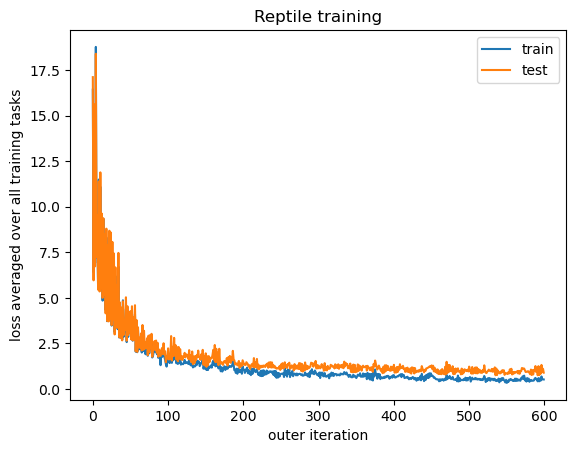

In [244]:
classifier = Classifier()
classifier_pretrained, losses_train, losses_test, accs_train, accs_test, learned_tasks = reptile_sgd(
    n_iters_outer=n_iters_outer,
    n_iters_inner=n_iters_inner,
    classifier=classifier,
    data_train=data_train,
    data_test=data_test,
    banned_task=(8,9),
    lr_inner=lr_inner,
    lr_outer=lr_outer)

plt.plot(range(len(losses_train)), losses_train, label="train")
plt.plot(range(len(losses_test)), losses_test, label="test")
plt.xlabel("outer iteration")
plt.ylabel("loss averaged over all training tasks")
plt.title("Reptile training")
plt.legend()
plt.show()

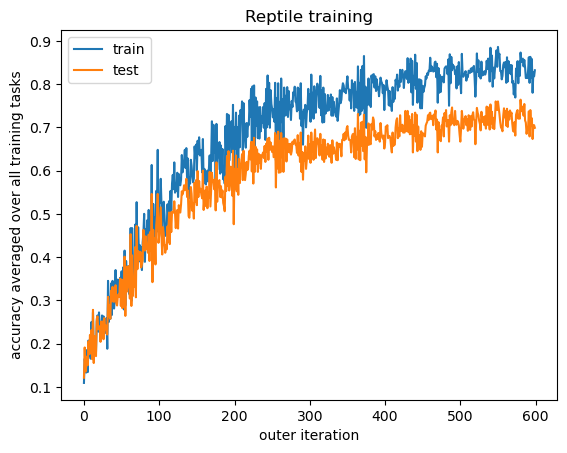

In [245]:
plt.plot(range(len(accs_train)), accs_train, label="train")
plt.plot(range(len(accs_test)), accs_test, label="test")
plt.xlabel("outer iteration")
plt.ylabel("accuracy averaged over all training tasks")
plt.title("Reptile training")
plt.legend()
plt.show()

# fine tuning to a seen task with just one update step
- almost perfect scores after just one fine tune update step

In [266]:
cls = deepcopy(classifier_pretrained)
fs_data_train = torch.cat([data_train[1][0], data_train[7][0]])
fs_target_train = torch.cat([data_train[1][1], data_train[7][1]])
fs_data_test = torch.cat([data_test[1][0], data_test[7][0]])
fs_target_test = torch.cat([data_test[1][1], data_test[7][1]])
print("1 vs 7 was trained", learned_tasks.count(set((7, 1))), "times in reptile")

print("zero shot results:")
with torch.no_grad():
    scores_train = cls(x=fs_data_train, y=fs_target_train)["scores"]
    scores_test = cls(x=fs_data_test, y=fs_target_test)["scores"]
    print("acc train:", acc(scores=scores_train, target=fs_target_train))
    print("acc test:", acc(scores=scores_test, target=fs_target_test))

print("\nafter just one training step:")
loss = cls(x=fs_data_train, y=fs_target_train)["loss"]
for param in cls.parameters():
    grad = torch.autograd.grad(loss, param, create_graph=True)[0]
    param.data.sub_(0.003 * grad)

with torch.no_grad():
    scores_train = cls(x=fs_data_train, y=fs_target_train)["scores"]
    scores_test = cls(x=fs_data_test, y=fs_target_test)["scores"]
    print("acc train:", acc(scores=scores_train, target=fs_target_train))
    print("acc test:", acc(scores=scores_test, target=fs_target_test))

1 vs 7 was trained 15 times in reptile
zero shot results:
acc train: 0.8849999904632568
acc test: 0.7799999713897705

after just one training step:
acc train: 0.9950000047683716
acc test: 0.9750000238418579


# few shot training on a new task on the seen data
- model never *directly* distinguished 8 vs 9, so the zero shot accuracy is close to random
- a single update step leads to huge improvement

In [278]:
cls = deepcopy(classifier_pretrained)
fs_data_train = torch.cat([data_train[8][0], data_train[9][0]])
fs_target_train = torch.cat([data_train[8][1], data_train[9][1]])
fs_data_test = torch.cat([data_test[8][0], data_test[9][0]])
fs_target_test = torch.cat([data_test[8][1], data_test[9][1]])

print("zero shot results:")
with torch.no_grad():
    scores_train = cls(x=fs_data_train, y=fs_target_train)["scores"]
    scores_test = cls(x=fs_data_test, y=fs_target_test)["scores"]
    print("acc train:", acc(scores=scores_train, target=fs_target_train))
    print("acc test:", acc(scores=scores_test, target=fs_target_test))

print("\nafter just one training step:")
loss = cls(x=fs_data_train, y=fs_target_train)["loss"]
for param in cls.parameters():
    grad = torch.autograd.grad(loss, param, create_graph=True)[0]
    param.data.sub_(0.002 * grad)

with torch.no_grad():
    scores_train = cls(x=fs_data_train, y=fs_target_train)["scores"]
    scores_test = cls(x=fs_data_test, y=fs_target_test)["scores"]
    print("acc train:", acc(scores=scores_train, target=fs_target_train))
    print("acc test:", acc(scores=scores_test, target=fs_target_test))

zero shot results:
acc train: 0.7149999737739563
acc test: 0.46000000834465027

after just one training step:
acc train: 0.9449999928474426
acc test: 0.875


\begin{tabular}{ccc}
& \text{seen data, seen task} & \text{seen data, new task} \\
\hline
\text{test accuracy after REPTILE} & 0.78 & 0.46 \\
\text{test accuracy one shot} & 0.98 & 0.88 \\
\end{tabular}